In [1]:
from generalized_hopfield_model import *
import matplotlib.pyplot as plt 
import scipy as sp 
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import umap

2025-03-21 22:04:05.520391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 22:04:05.547540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0.5, 1.0, 'Digit 5')

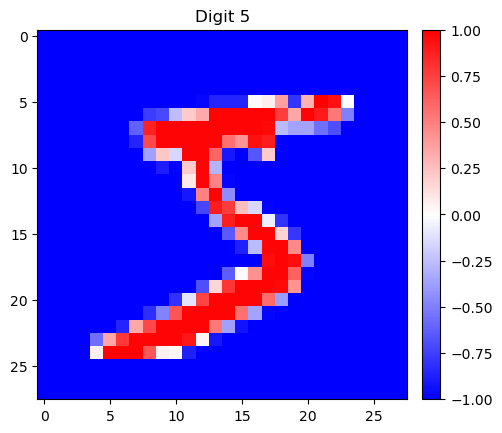

In [2]:
#get MNIST digits and labels 
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

#format labels such that each image corresponds to a 10 length vector. Digit corresponds to the position with value 1, otherwise values are -1 
all_y = y.astype(np.int64)
all_Ls = -1*np.ones((all_y.shape[0],10))
all_Ls[np.arange(y.shape[0]),all_y] = 1 

#renormalize digit pixel values to values in [-1,1] 
all_Ms = 2*X/np.max(X) - 1.0

#plot a digit
digit_idx = 0
fig,ax = plt.subplots()
im = ax.imshow(all_Ms[digit_idx].reshape(28,28), cmap='bwr', vmin=-1, vmax=1)
cax = ax.inset_axes([1.04, 0.0, 0.05, 1.0])
cbar = fig.colorbar(im,cax=cax)
ax.set_aspect('equal')
ax.set_title('Digit '+str(np.argmax(all_Ls[digit_idx])))

In [3]:
# choose parameters for generalized hopfield network (GHN)
M_len = int(28*28) # length of memories; length of flattened digit pixels
L_len = 10 # length of label vector; 10 digits (0,1,2,3,4,5,6,7,8,9)
N_mem = 200 # number of memories in our GHN
n_deg = 30 # exponent of the f_n function of the GHN
Temperature = 0.85*M_len # pseudo-temperature of the f_n argument
learning_rate = 0.005 # learning rate by which we nudge the memories and labels in direction of their gradient
# we initialize memories and labels (which will be optimized) using normal distributions with the following moments
rand_mean = -0.003 # mean
rand_std = 1e-5 # standard deviation

# we instantiate/create the network 
net = GHN(M_len=M_len, L_len=L_len, K=N_mem, n_deg=n_deg, Temp=Temperature, m_deg=n_deg, dt=learning_rate, momentum=0., rand_mean=rand_mean, rand_std=rand_std)

In [4]:
# divide digits and labels into training and test sets (although we do not test in this notebook)
N_imgs = len(y)
N_train = 60000
N_test = N_imgs - N_train

train_y = all_y[:N_train]
train_Ls = all_Ls[:N_train]
train_Ms = all_Ms[:N_train]

def get_digits_idxs(sel_digits,Set,Num):
    # function which extracts specific number of samples per selected digits from a specific set
    d_idxs = np.empty(len(sel_digits)*Num, dtype=np.int64)
    for i,dig in enumerate(sel_digits):
        dig_idxs = np.where(Set == dig)[0]
        d_idxs[i*Num:(i+1)*Num] = dig_idxs[:Num]
    return d_idxs

SDs = np.arange(10) # which digits do we want to train our network 
N_digit_samples = 100 # number of samples to which to train each digit

t_idxs = get_digits_idxs(SDs, train_y, N_digit_samples)

# training variables 
t_Ls = train_Ls[t_idxs,:] #training labels 
t_Ms = train_Ms[t_idxs,:] #traning memories/digits 
epochs = 5000 

# saving trained memories and labels parameters 
t_resolution = 5 
lib_Ms = np.empty((epochs//t_resolution, N_mem, int(28*28)))
lib_Ls = np.empty((epochs//t_resolution, N_mem, 10))

# training cycle
for k in range(epochs):
    net.train_protocol(t_Ms, t_Ls, 0.0, 0.0)
    if k%t_resolution == 0:
        lib_Ms[k//t_resolution] = net.Ms
        lib_Ls[k//t_resolution] = net.Ls
        print('done with '+str(k)+' epochs')

done with 0 epochs
done with 5 epochs
done with 10 epochs
done with 15 epochs
done with 20 epochs
done with 25 epochs
done with 30 epochs
done with 35 epochs
done with 40 epochs
done with 45 epochs
done with 50 epochs
done with 55 epochs
done with 60 epochs
done with 65 epochs
done with 70 epochs
done with 75 epochs
done with 80 epochs
done with 85 epochs
done with 90 epochs
done with 95 epochs
done with 100 epochs
done with 105 epochs
done with 110 epochs
done with 115 epochs
done with 120 epochs
done with 125 epochs
done with 130 epochs
done with 135 epochs
done with 140 epochs
done with 145 epochs
done with 150 epochs
done with 155 epochs
done with 160 epochs
done with 165 epochs
done with 170 epochs
done with 175 epochs
done with 180 epochs
done with 185 epochs
done with 190 epochs
done with 195 epochs
done with 200 epochs
done with 205 epochs
done with 210 epochs
done with 215 epochs
done with 220 epochs
done with 225 epochs
done with 230 epochs
done with 235 epochs
done with 240 

ValueError: cannot reshape array of size 156800 into shape (1,400,784)

In [6]:
# save trayectory of trained parameters of the GHN; (# of cycles, # of memories in GHN, vector length)
np.save('Mems_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy', np.concatenate((lib_Ms,net.Ms.reshape((1,N_mem,M_len)))))
np.save('Labels_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy', np.concatenate((lib_Ls,net.Ls.reshape((1,N_mem,L_len)))))

In [ ]:
# we can load predefined memory and label states 
#lib_Ms = np.load('Mems_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy')
#lib_Ls = np.load('Labels_n_deg_'+str(n_deg)+'_T_'+str(Temperature)+'_K_'+str(N_mem)+'_N-d-samps_'+str(N_digit_samples)+'_epochs_'+str(epochs)+'_t-resolution_'+str(t_resolution)+'.npy')
#net = GHN(M_len=M_len, L_len=L_len, K=N_mem, n_deg=n_deg, Temp=Temperature, m_deg=n_deg, dt=learning_rate, momentum=0., rand_mean=rand_mean, rand_std=rand_std, Mems=lib_Ms[-1], Labels=lib_Ls[-1])


[-0.04916124 -0.04925542 -0.04911046  0.0410983  -0.04930162 -0.04282942
 -0.04924008 -0.04919617 -0.04708847 -0.04920385] True


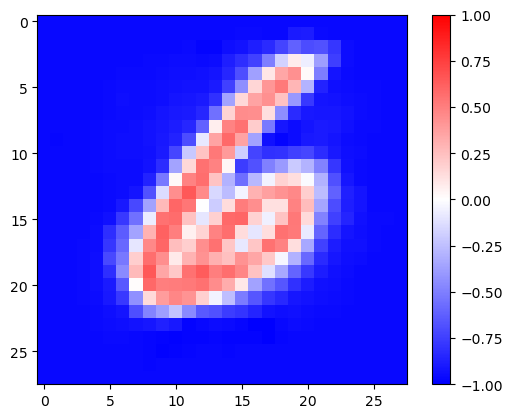

In [24]:
# we could test how well our model can classify a test case; this could definitely be done more efficiently or in a loop to quantify the network's ability 
test_idx = 500
net.output(all_Ms[N_train+test_idx])
print(net.output(all_Ms[N_train+test_idx]), np.argmax(net.output(all_Ms[N_train+test_idx])) == all_y[N_train+test_idx])

# Let's analyze a memory in our GHN which exhibits a prototype of a digit, this means that the memory's label should have -1 everywhere 
# in the label vector except in the position of the memory's corresponding digit where it should be very close to 1

# we can analyze the feature-to-prototype transition by looking at how memories are composed with respect to the training set digits! 
# the following calculates the weights by applying the Moore-Penrose inverse of the training set digits, by which we multiply it with the 
# memories of the GHN
alphas = net.Ms @ sp.linalg.pinv(t_Ms)

# this loop finds all memories that hold/are prototypes! 
L_idxs = []
for i_L,L in enumerate(net.Ls):
    if np.abs(np.abs(np.sum(L)) - 8) < 1e-3: # this finds vectors where all digits are -1 except in on position. The memory's digit
        L_idxs.append(i_L)
        # break


L_idx = np.random.choice(L_idxs) # selects one of these memories to plot the memory's espective weights! 

# let's plot the memory to see if indeed it is a prototype of a digit!
fig, ax = plt.subplots() 
im = ax.imshow(net.Ms[L_idx].reshape((28,28)), cmap='bwr', vmin=-1, vmax=1)
ax.set_aspect('equal')
plt.colorbar(im)

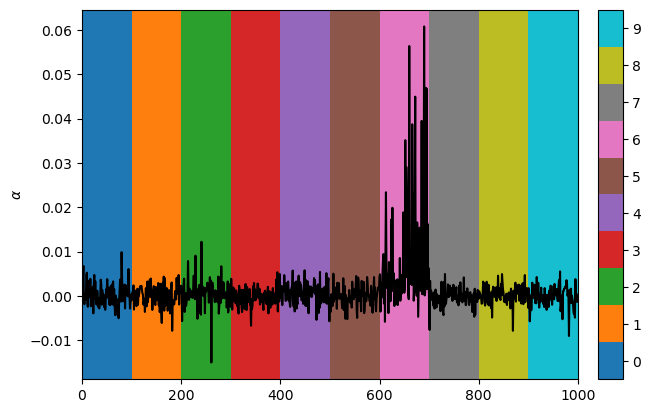

In [25]:
# the weights alpha should reflect this protoype by showing a maximum with respect to training digits that correspond to the prototype digit 
# it is important to have a colormap to show how the weights correspond to different digits 
cmap = plt.get_cmap('tab10')
norm = mpl.colors.Normalize(vmin=-0.5, vmax=9.5)
scalarMap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# plot the distribution of alphas for a prototype memory 
fig, ax = plt.subplots() 
ax.plot(np.arange(len(SDs)*N_digit_samples), alphas[L_idx], color='k') # this can be binned to be smoother, or savgol could also be sufficient

# color background of plot for range of digit alphas correspond to
for k in range(10):
    ax.axvspan(k*N_digit_samples, (k+1)*N_digit_samples, facecolor=scalarMap.to_rgba(k))

ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0,len(SDs)*N_digit_samples)
cax = ax.inset_axes([1.04, 0.0, 0.05, 1.0])
cbar = fig.colorbar(scalarMap, ax=ax, cax=cax, cmap=cmap, ticks=np.arange(10))
plt.show()

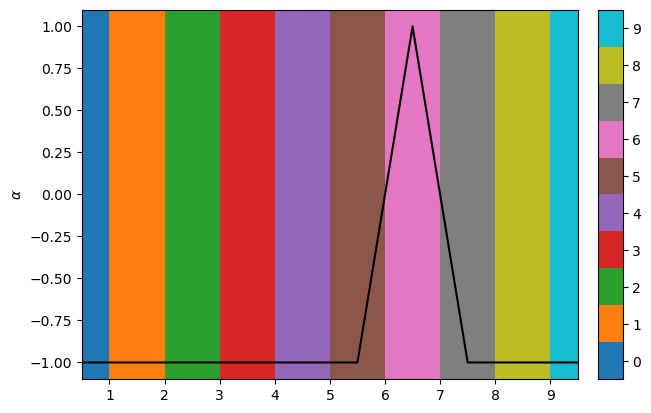

In [26]:
# plot label of this memory to show that indeed it classifies this prototype correctly!
fig, ax = plt.subplots() 
ax.plot(np.arange(10)+0.5, net.Ls[L_idx], color='k') #we are essentially plotting the distribution of the alphas as a function of the digit they were trained with 

for k in range(10):
    ax.axvspan(k, (k+1), facecolor=scalarMap.to_rgba(k))

ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0.5,9.5)
cax = ax.inset_axes([1.04, 0.0, 0.05, 1.0])
cbar = fig.colorbar(scalarMap, ax=ax, cax=cax, cmap=cmap, ticks=np.arange(10))
plt.show()

In [10]:
# we visualize the dynamics of learning of the GHN using the UMAP! We do this by obtaining the manifold of the training set digits to obtain 
# a general manifold in many dimensions!   
MNIST_dat_map = umap.UMAP(random_state=4, n_neighbors=55, min_dist=0.05, metric='correlation').fit(train_Ms)

# we embed a fraction of the training digits in this manifold, along with the memories at different times of the training protocol! 
train_embedding = MNIST_dat_map.transform(train_Ms[::10])

/home/hector/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hector/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/hector/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/home/hector/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


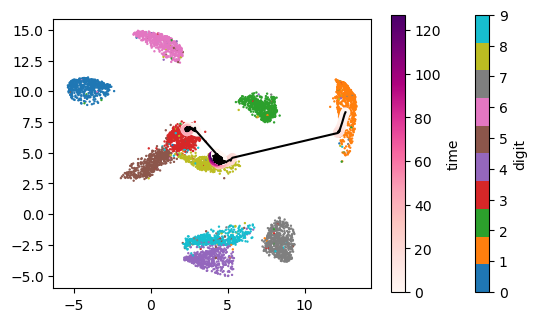

In [11]:
# we look at the dynamics of learning of a single memory starting from t = 80*5 cycles to 110*5 cycles later 
mems_idxs = [1] 
offset = 40
t_span_mems = np.arange(300,dtype=np.int8)
mem_t = np.empty((t_span_mems.size,M_len))
for k in range(t_span_mems.size):
    mem_t[k] = lib_Ms[offset+k][mems_idxs]

# fit and transform training data using the same manifold obtained from the training data
mem_embedding = MNIST_dat_map.transform(mem_t)

fig, ax = plt.subplots()     
digit_manifold = ax.scatter(train_embedding[:,0], train_embedding[:,1], s=0.5, c=train_y[::10], cmap=cmap) # points of the trajectory of the memory, colored by time
traj_mem = ax.scatter(mem_embedding[:,0], mem_embedding[:,1], c=t_span_mems, cmap='RdPu', vmin=0) # connecting line of the trayectory
ax.plot(mem_embedding[:,0], mem_embedding[:,1], c='k')
ax.set_aspect(0.8)
digit_cb = plt.colorbar(digit_manifold,shrink=0.75,ticks=np.arange(10))
digit_cb.set_label('digit')
t_cb = plt.colorbar(traj_mem,shrink=0.75)
t_cb.set_label('time')

/home/hector/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hector/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


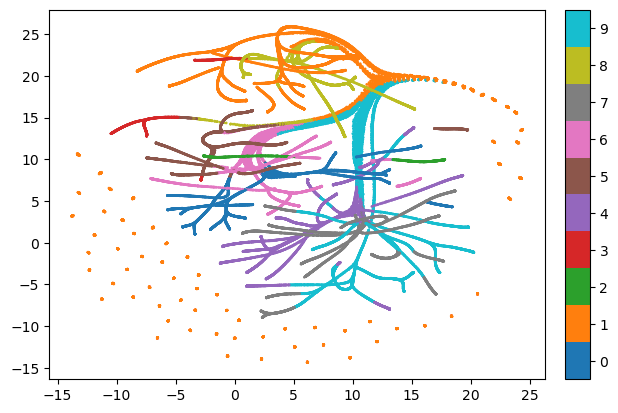

In [30]:
# we can also visualize the manifold of the contributing weights of the training set to the memories and color them 
# according to the digit the memory represents. The color is chosen by taking the maximum of the memory's label vector and 
# color according to the position of the maximum value
every = 2
alphas_t = lib_Ms[offset][::every] @ sp.linalg.pinv(t_Ms[::every]) # calculates the alphas 
L_alphas_t = np.argmax(lib_Ls[offset][::every], axis=1) #get's the digit of the memory at time t = offset*5

for k in range(1,500):
    alphas_t = np.concatenate((alphas_t, lib_Ms[offset+k][::every] @ sp.linalg.pinv(t_Ms[::every])))
    L_alphas_t = np.concatenate((L_alphas_t, np.argmax(lib_Ls[offset+k][::every], axis=1)))

alphas_embedding = umap.UMAP(random_state=4, n_neighbors=800, low_memory=True).fit_transform(alphas_t) #calculates the approximate uniform manifold and projects it onto 2D space 

fig, ax = plt.subplots()     
ax.scatter(alphas_embedding[:,0], alphas_embedding[:,1], s=1, c=L_alphas_t, cmap=cmap)
cax = ax.inset_axes([1.04, 0.0, 0.05, 1.0])
digit_cbar = fig.colorbar(scalarMap, ax=ax, cax=cax, cmap=cmap, ticks=np.arange(10), alpha=1.0)
